https://www.kaggle.com/code/hothothot/lab4-nlp?scriptVersionId=158610806

In [1]:
import re
import typing as t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice, chain
from functools import partial
from pathlib import Path

import torch, torchtext, torchdata
import torch.nn as nn
from torchdata import datapipes
from torchdata.datapipes.iter import IterableWrapper
from torchtext import transforms
from torchtext.vocab import build_vocab_from_iterator

In [2]:
SEED = 212

# random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [53]:
def pdp(datapipe: datapipes.iter.IterDataPipe | t.Iterable, n: int = None) -> None:
    print(type(datapipe))

    for sample in islice(datapipe, n):
        print(sample)

In [54]:
src = '/kaggle/input/tiny-stories-ds/TinyStoriesV3-GPT4-train.txt'

In [55]:
dp = IterableWrapper([src])
dp = dp.open_files(encoding='utf-8').readlines()
# datapipe = datapipe.shuffle().sharding_filter()
# datapipe = datapipe.map(fn).batch(8)

In [56]:
pdp(dp, 2)

<class 'torchdata.datapipes.iter.util.plain_text_reader.LineReaderIterDataPipe'>
('/kaggle/input/tiny-stories-ds/TinyStoriesV3-GPT4-train.txt', "Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase. When Ben saw it he was amazed!  He said, “Wow, that is a really amazing vase! Can I buy it?” The shopkeeper smiled and said, “Of course you can. You can take it home and show all your friends how amazing it is!”So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. And that's how Ben found an amazing vase in the store!")
('/kaggle/input/tiny-stories-ds/TinyStoriesV3-GPT4-train.txt', 'Once upon a time, there was a reliable otter named Ollie. He l

In [57]:
# len([i for i in islice(dp, 4000000)])

#### 

In [58]:
N = 2717700

In [ ]:
pdp(dp, 1)

In [ ]:
a = """Одн...,нажды,в студеную зимнюю пору
Я из лесу вышел;был сильный мороз.Гляжу,подни.,;мается1в гору
Лошадка,везущая хворосту воз.k"""
re.sub(r'([.,;])\1*', r'\1 ', a)

In [59]:
exp1 = re.compile(r'[^a-zA-Zа-яА-Я0-9 ,\.\'!?:]')
exp2 = re.compile(r'([,.!?:])\1*')
exp3 = re.compile(r' +')


def re_filter(x):
    x = re.sub(pattern=exp1, repl=' ', string=x)
    x = re.sub(pattern=exp2, repl=r'\1 ', string=x)
    x = re.sub(pattern=exp3, repl=' ', string=x)
    return x


max_chars = 128 - 2 # 768

dp = IterableWrapper([src])
dp = dp.open_files(encoding='utf-8').readlines()
dp = dp.map(lambda x: x[1])
dp = dp.map(re_filter)
# dp = dp.filter(lambda x: len(x) <= max_chars)
dp = dp.map(lambda x: x[:max_chars])

In [60]:
dp_buf = list(islice(dp, 100_000))
print(len(dp_buf))

100000


In [61]:
dp = IterableWrapper(dp_buf)

In [62]:
pdp(dp, 1)

<class 'torch.utils.data.datapipes.iter.utils.IterableWrapperIterDataPipe'>
Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like


In [63]:
build_vocab_from_iterator(
    ['abcd', 'fghj'],
    min_freq=1,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True,
).get_itos()

['<pad>', '<sos>', '<eos>', '<unk>', 'a', 'b', 'c', 'd', 'f', 'g', 'h', 'j']

In [64]:
voc = build_vocab_from_iterator(
    dp,
    min_freq=1,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True,
)
voc.set_default_index(voc['<unk>'])

In [65]:
voc.get_itos()

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 ' ',
 'e',
 'a',
 't',
 'n',
 'i',
 'o',
 'd',
 'h',
 'l',
 's',
 'r',
 'm',
 'w',
 'y',
 '.',
 'u',
 'p',
 'c',
 'g',
 ',',
 'b',
 'O',
 'f',
 'T',
 'k',
 'v',
 'S',
 'H',
 'L',
 'M',
 'x',
 'B',
 'I',
 'A',
 'j',
 'J',
 'E',
 'z',
 "'",
 'F',
 'q',
 'K',
 'D',
 'W',
 '!',
 'P',
 'C',
 'R',
 'G',
 '?',
 '3',
 'Z',
 'N',
 'V',
 'Y',
 ':',
 'U',
 'Q',
 'X',
 '1',
 '4',
 '5',
 '0',
 '2',
 '7',
 '8',
 '9']

In [66]:
def make_src_doc_transform(vocab: torchtext.vocab.Vocab) -> transforms.Sequential:
    doc_transform = transforms.Sequential(
        transforms.VocabTransform(vocab=vocab),
#         transforms.AddToken(vocab['<sos>'], begin=True),
#         transforms.AddToken(vocab['<eos>'], begin=False),
    )
    return doc_transform

def make_trg_doc_transform(vocab: torchtext.vocab.Vocab) -> transforms.Sequential:
    doc_transform = transforms.Sequential(
        transforms.VocabTransform(vocab=vocab),
        # Переосмыслпение блять
        transforms.AddToken(vocab['<sos>'], begin=True),  # декодер должен начать продолжать историю
        transforms.AddToken(vocab['<eos>'], begin=False),
    )
    return doc_transform

In [67]:
src_doc_transform = make_src_doc_transform(voc)
trg_doc_transform = make_trg_doc_transform(voc)

In [68]:
(max_chars * 0.3, max_chars * 0.7), (max_chars * 0.6, max_chars * 0.4)

((37.8, 88.19999999999999), (75.6, 50.400000000000006))

In [69]:
MAX_SEQ_LEN = max_chars + 2  # # 540  # +2 sos eos

In [70]:
def split_to_XY(doc) -> tuple[list[str, ...], list[str, ...]]:
#     x = doc.split()  # была погрешность в размерностях из-за слов
    x = doc  # пусть будет просто по символам
    a, b = 0.49, 0.5
    ln = int(len(x) * (a + (b - a) * torch.rand(1)))
    x1, x2 = x[:ln], x[ln:]
#     return list(' '.join(x1)), list(' '.join(x2))
    return list(x1), list(x2)


def split_transform_to_XY(doc) -> tuple[list[int, ...], list[int, ...]]:
    x1, x2 = split_to_XY(doc)
    return src_doc_transform(x1), trg_doc_transform(x2)
#     return src_doc_transform(x1), src_doc_transform(x2)


def bXY_to_bXbY(batch):
    """
        :param batch: list[tuple[[int, ...], [int, ...]], ...]
        :return: batch list[tuple[[int, ...], ...], tuple[[int, ...], ...]]
    """
    return list(zip(*batch))

In [71]:
# aa = """One day, a boy named Tim went to the park. He saw a big tiger. The tiger was not mean, but very easy to play with. Tim and the tiger played all day. They had lots of fun.Then, something unexpected happened. The tiger started to shake. Tim was scared. He did not know what was going on. But then, the tiger turned into a nice dog. Tim was very surprised.Tim and the dog played together now. They were very happy. The dog was easy to play with too. At the end of the day, Tim went home with his new friend."""

# np.array(trg_doc_transform(split_to_XY(aa)[1]));

In [72]:
dp = dp.map(split_transform_to_XY)

dp = dp.bucketbatch(
    batch_size=128,
    use_in_batch_shuffle=True,
)
dp = dp.map(bXY_to_bXbY)

In [73]:
def apply_padding(bXbY, pad_transforms=None):
    X, Y = bXbY
    X_ = transforms.ToTensor(voc['<pad>'])(list(X))
    Y_ = transforms.ToTensor(voc['<pad>'])(list(Y))
    if pad_transforms:
        X_pad_transform, Y_pad_transform = pad_transforms
        X_ = X_pad_transform(X_)
        Y_ = Y_pad_transform(Y_)
    return (X_, Y_)

In [74]:
# pts = (
#     transforms.PadTransform(461, voc['<pad>']),
#     transforms.PadTransform(539, voc['<pad>']),  # +1 <eos>
# )
pts = (
    transforms.PadTransform(MAX_SEQ_LEN, voc['<pad>']),
    transforms.PadTransform(MAX_SEQ_LEN, voc['<pad>']),
)
dp = dp.map(partial(apply_padding, pad_transforms=pts))

In [75]:
pdp(dp, 1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(tensor([[26,  8, 22,  ...,  0,  0,  0],
        [26,  8,  5,  ...,  0,  0,  0],
        [26,  8, 22,  ...,  0,  0,  0],
        ...,
        [26,  8, 22,  ...,  0,  0,  0],
        [33,  9, 13,  ...,  0,  0,  0],
        [26,  8, 22,  ...,  0,  0,  0]]), tensor([[ 1, 10,  8,  ...,  0,  0,  0],
        [ 1,  4, 28,  ...,  0,  0,  0],
        [ 1,  8, 10,  ...,  0,  0,  0],
        ...,
        [ 1, 11,  4,  ...,  0,  0,  0],
        [ 1,  4, 12,  ...,  0,  0,  0],
        [ 1,  7, 10,  ...,  0,  0,  0]]))


In [76]:
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, embed_dim):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(seq_len, embed_dim)  # [seq_len, embed_dim]
        pos = torch.arange(0, seq_len, dtype=torch.long).unsqueeze(1)  # [seq_len, 1]
        i = torch.arange(0, embed_dim, dtype=torch.long)  # [embed_dim]
        
        buf = pos / 10000 ** (i / embed_dim)
        pe[..., 0::2] = torch.sin(buf)[..., 0::2]
        pe[..., 1::2] = torch.cos(buf)[..., 1::2]
        
        self.register_buffer('pe', pe.to(DEVICE))

    def forward(self, x):
        """
        Args:
            x: embedded input ~ [batch_size, seq_len, embed_dim]
        Returns:
            out: positional encoded ~ [batch_size, seq_len, embed_dim]
        """
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :]

In [77]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        super(MultiHeadAttention, self).__init__()

        assert embed_dim % n_heads == 0
        
        self.embed_dim = embed_dim  # d_model
        self.n_heads = n_heads
        self.single_head_dim = int(self.embed_dim / self.n_heads)

        self.n_head = n_heads
        self.Wq = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.Wk = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.Wv = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.Wo = nn.Linear(self.single_head_dim * self.n_heads, self.embed_dim)

    def split_into_heads(self, item, n_heads, dim_head):
        batch_size, seq_len, _ = item.shape  # [batch_size, seq_len, embed_dim]
        pre_heads = item.view(batch_size, seq_len, n_heads, dim_head)
        return pre_heads.transpose(1, 2)  # [batch_size, n_head, seq_len, dim_head]

    def join_heads(self, heads, d_model):
        batch_size, _, seq_len, _ = heads.shape
        return heads.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)  # [batch_size, seq_len, embed_dim]

    def forward(self, Q, K, V, with_mask=False):
        """
        Args:
            Q: [batch_size, seq_len, embed_dim]
            K: [batch_size, seq_len, embed_dim]
            V: [batch_size, seq_len, embed_dim]
            with_mask: for decoder
        Returns:
            out: [batch_size, seq_len, embed_dim]
        """

        Q_heads = self.split_into_heads(Q, self.n_head, self.single_head_dim)
        K_heads = self.split_into_heads(K, self.n_head, self.single_head_dim)
        V_heads = self.split_into_heads(V, self.n_head, self.single_head_dim)

        Q_heads = self.Wq(Q_heads)
        K_heads = self.Wk(K_heads)
        V_heads = self.Wv(V_heads)

        product = Q_heads.matmul(K_heads.transpose(-2, -1)) / np.sqrt(self.single_head_dim)  # [batch_size, n_head, seq_len, seq_len]

        if with_mask:
            batch_size, seq_len, _ = Q.shape
            mask = torch.tril(torch.ones(seq_len, seq_len)).expand(batch_size, 1, seq_len, seq_len).to(DEVICE)
            product = product.masked_fill(mask == 0, float('-1e20'))  # -inf

        scores = torch.softmax(product, dim=-1)  # [batch_size, n_head, seq_len, seq_len]
        scores = scores @ V_heads  # [batch_size, n_head, seq_len, dim_head]
        H = self.join_heads(scores, self.embed_dim)  # [batch_size, seq_len, embed_dim]

        return self.Wo(H)  # [batch_size, seq_len, embed_dim]

In [78]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads=8, expansion_factor=4, dropout=0.2):
        super(TransformerBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_dim, n_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, int(expansion_factor * embed_dim)),
            nn.Mish(),
            nn.Linear(int(expansion_factor * embed_dim), embed_dim),
        )

    def forward(self, q, k, v):
        attention_out = self.attention(q, k, v)
        x = self.norm1(v + self.dropout(attention_out))

        ff = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff))

        return x

In [79]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, n_heads=8, expansion_factor=4, dropout=0.2):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_dim=embed_dim, n_heads=n_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.transformer_block = TransformerBlock(
            embed_dim=embed_dim,
            n_heads=n_heads,
            expansion_factor=expansion_factor,
            dropout=dropout,
        )

    def forward(self, q, k, v):
        attention_out = self.attention(q, k, v, with_mask=True)
        decoder_value = self.norm(v + self.dropout(attention_out))
        out = self.transformer_block(
            q=q,
            k=k,
            v=decoder_value,
        )
        return out

In [80]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, seq_len, num_layers=2, n_heads=8, expansion_factor=4, dropout=0.2):
        super(TransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pe = PositionalEncoding(seq_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            DecoderBlock(embed_dim, n_heads=n_heads, expansion_factor=expansion_factor, dropout=dropout) 
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, encoder_out):
        """
        Args:
            x: [batch_size, seq_len]
            encoder_out: [batch_size, seq_len, embed_dim]
        Returns:
            out: logits ~ [batch_size, seq_len, vocab_size]
        """

        x = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        x = self.pe(x)  # [batch_size, seq_len, embed_dim]
        x = self.dropout(x)
     
        i = 0
        for layer in self.layers:
            x = layer(q=x, k=encoder_out, v=encoder_out)

        x = self.fc(x)
        # out = torch.softmax(x, dim=2)  # Софтмакс уже есть в Кросс-энтропии

        return x

In [81]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, seq_len, num_layers=2, n_heads=8, expansion_factor=4, dropout=0.2):
        super(TransformerEncoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pe = PositionalEncoding(seq_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim,
                n_heads=n_heads,
                expansion_factor=expansion_factor,
                dropout=dropout,
            )
            for _ in range(num_layers)
        ])

    def forward(self, x):
        """  # взят с TransformerDecoder
        Args:
            x: [batch_size, seq_len]
        Returns:
            out: [batch_size, seq_len, embed_dim]
        """

        x = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        x = self.pe(x)  # [batch_size, seq_len, embed_dim]
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(q=x, k=x, v=x)

        return x

In [82]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, vocab_size, seq_len, num_layers=2, n_heads=8, expansion_factor=4, dropout=0.2,
#                  device='cpu'
                ):
        super(Transformer, self).__init__()

#         self.device = device
        self.vocab_size = vocab_size
        self.encoder = TransformerEncoder(vocab_size, embed_dim, seq_len, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(vocab_size, embed_dim, seq_len, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pe = PositionalEncoding(seq_len, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def mock_encoder(self, x):
        return self.encoder(x)

    def decode(self, prompt):
        batch_size, prompt_len = prompt.shape

#         encoder_out = self.mock_encoder(prompt)  # как быть если увеличивается длина во время генерации (в MHA матрица не квадратная)

        outputs = prompt  # [batch_size, prompt_seq_len]
        outputs = torch.ones(batch_size, 1, dtype=torch.int).to(DEVICE)

        for i in range(MAX_SEQ_LEN - prompt_len):
            encoder_out = self.mock_encoder(outputs)  # или ноли добавить
            logits = self.decoder(outputs, encoder_out)  # [batch_size, cur_seq_len, vocab_size]
            label = logits[:, -1, :].unsqueeze(1).softmax(2).argmax(2)  # [batch_size, 1]
            outputs = torch.concat((outputs, label), dim=1)

        return outputs

    def forward(self, src, trg):
        """
        Args:
            src: input to encoder 
            trg: input to decoder
        Returns:
            out: logits ~ [batch_size, seq_len, vocab_size]
        """
        encoder_out = self.mock_encoder(src)
        outputs = self.decoder(trg, encoder_out)
        return outputs

In [83]:
lr = 1e-3
loss = nn.CrossEntropyLoss(ignore_index=0)

transformer = Transformer(
    embed_dim=256,
    vocab_size=len(voc),
    seq_len=MAX_SEQ_LEN,
    num_layers=4,
    n_heads=8,
    expansion_factor=2,
    dropout=0.2,
#     device=DEVICE,
)
transformer = nn.DataParallel(transformer, device_ids=[0, 1])
transformer = transformer.to(DEVICE)
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

all(all(param.is_cuda for param in model.parameters()) for model in (transformer,))

True

In [84]:
transformer

DataParallel(
  (module): Transformer(
    (encoder): TransformerEncoder(
      (embedding): Embedding(72, 256)
      (pe): PositionalEncoding()
      (dropout): Dropout(p=0.2, inplace=False)
      (layers): ModuleList(
        (0-3): 4 x TransformerBlock(
          (attention): MultiHeadAttention(
            (Wq): Linear(in_features=32, out_features=32, bias=False)
            (Wk): Linear(in_features=32, out_features=32, bias=False)
            (Wv): Linear(in_features=32, out_features=32, bias=False)
            (Wo): Linear(in_features=256, out_features=256, bias=True)
          )
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (feed_forward): Sequential(
            (0): Linear(in_features=256, out_features=512, bias=True)
            (1): Mish()
            (2): Linear(in_features=512, out_features=256, bias=True)
        

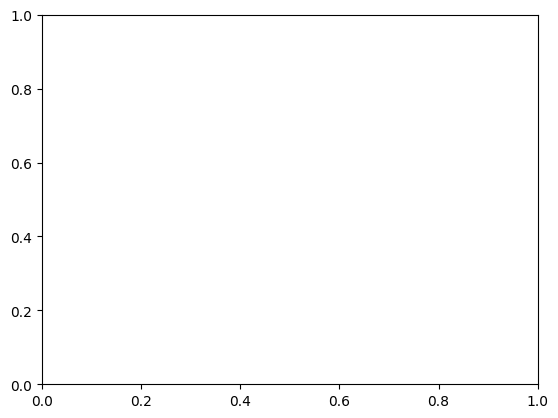

In [85]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
d = deque(maxlen=2)
d.append([0, 0])
i = 0

In [44]:
from tqdm import tqdm

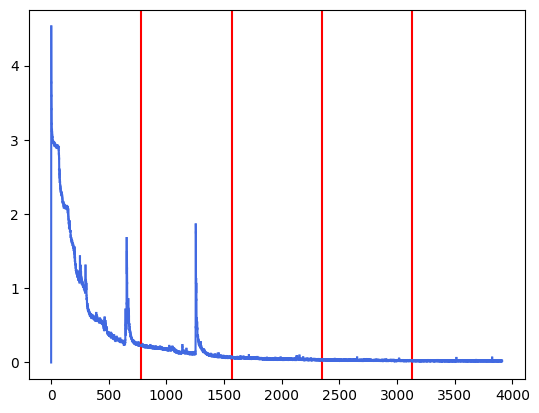

In [101]:
epochs = 1
transformer.train()

for epoch in range(epochs):
    print(f'[Transformer] Epoch {epoch + 1}...')
    epoch_loss = 0.
    for x_b, y_b in dp:
        i += 1
        x_b = x_b.to(DEVICE)
        y_b = y_b.to(DEVICE)

        optimizer.zero_grad()
        outputs = transformer(x_b, y_b)
        loss_value = loss(outputs.permute(0, 2, 1), y_b)
        epoch_loss += loss_value.item()

        # # graph
        d.append([i, loss_value.item()])
        ax.plot(*zip(d[0], d[1]), color='royalblue')
        display(fig)
        clear_output(wait=True)
#         plt.pause(0.01)
        # #

        loss_value.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1)

    scheduler.step()
    ax.axvline(x=i, color='r')

loss при одинаковых X, Y: модель научилась повторять промпт (была ошибка в инференсе)

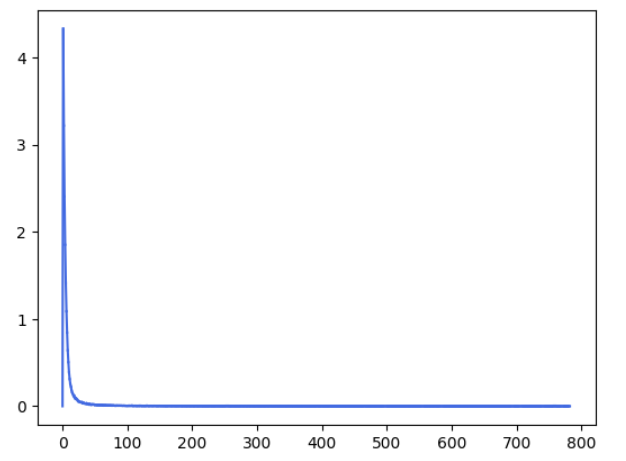


X - 0.3-0.5*len, Y - all

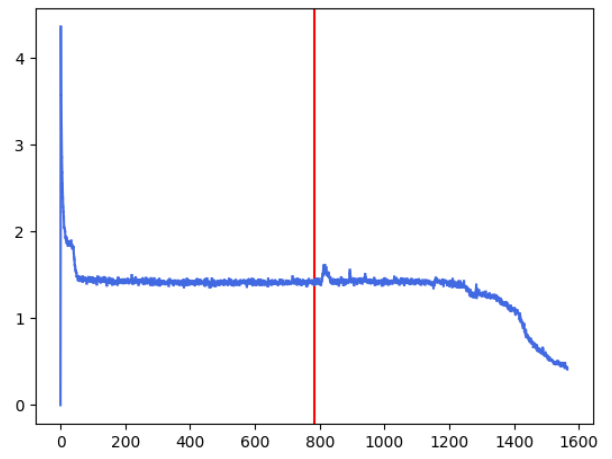

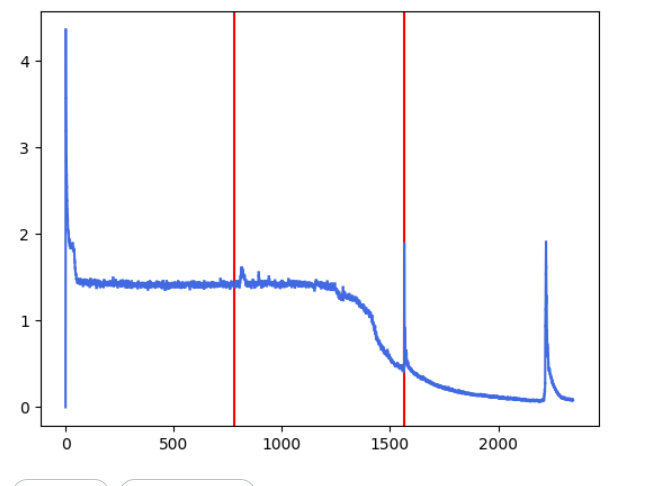


X - 0.3-0.5*len, Y - second part of doc

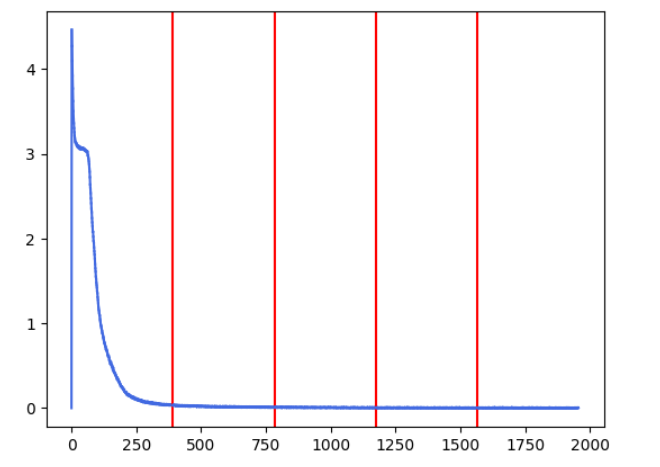

Увеличил параметры

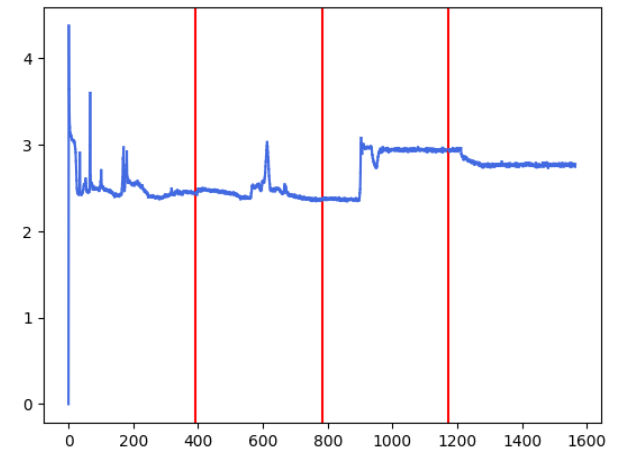

Добавил Енкодер и поменял параметры

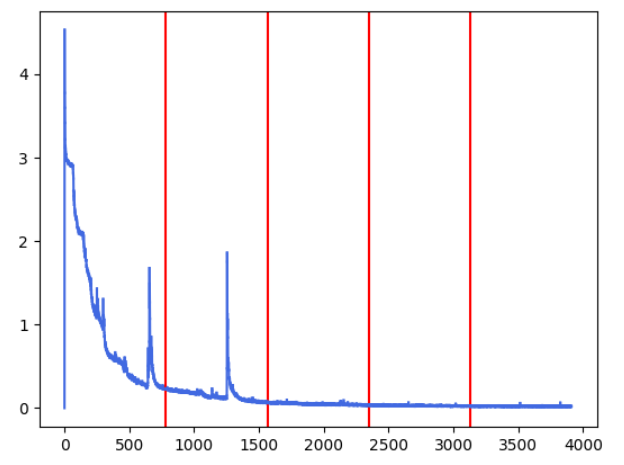

In [ ]:
torch.save(transformer.state_dict(), './tf_ep2_50k.pt')

In [ ]:
checkpoint = torch.load('/kaggle/working/tf_ep2_50k.pt', map_location=torch.device('cpu'))

transformer.load_state_dict(checkpoint)

In [ ]:
transformer.to(DEVICE);

In [87]:
def make_test_dp(prompt: list[str]):
    def apply_padding(X):
        print(X)
        X = transforms.ToTensor(voc['<pad>'], dtype=torch.int64)(list(X))
#         X = transforms.PadTransform(MAX_SEQ_LEN, voc['<pad>'])(X)
        return X

    dp = IterableWrapper(prompt)
    dp = dp.map(re_filter)
    dp = dp.map(lambda x: src_doc_transform(list(x[:MAX_SEQ_LEN])))
    dp = dp.bucketbatch(
        batch_size=1,
        use_in_batch_shuffle=False,
    )
#     dp = dp.map(bXY_to_bXbY)
    dp = dp.map(apply_padding)

    return dp

In [103]:
transformer.eval()

src = [
    'Once upon a time there was a little boy named Ben. ',
    'Once upon i want to walk with you',
    'We are nedd to go for a walk!',
]
# Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the store when he came across a very special vase.
#  When Ben saw it he was amazed! He said, Wow, that is a really amazing vase! Can I buy it? The shopkeeper smiled and said, Of course you can. You can take it home and show all your friends how amazing it is! So Ben took the vase home and he was so proud of it! He called his friends over and showed them the amazing vase. All his friends thought the vase was beautiful and couldn't believe how lucky Ben was. And that's how Ben found an amazing vase in the store!

res = []
with torch.no_grad():
    for x_b in make_test_dp(src):
        x_b.to(DEVICE)
        outputs = (
            transformer
            .module
            .decode(x_b.to(DEVICE))
        )
        print(outputs.shape)
        res.append(outputs)

[[26, 8, 22, 5, 4, 20, 21, 10, 8, 4, 6, 4, 7, 9, 16, 5, 4, 7, 12, 5, 15, 5, 4, 17, 6, 14, 4, 6, 4, 13, 9, 7, 7, 13, 5, 4, 25, 10, 18, 4, 8, 6, 16, 5, 11, 4, 36, 5, 8, 19, 4]]
torch.Size([1, 78])
[[48, 5, 4, 6, 15, 5, 4, 8, 5, 11, 11, 4, 7, 10, 4, 23, 10, 4, 27, 10, 15, 4, 6, 4, 17, 6, 13, 29, 49, 4]]
torch.Size([1, 99])
[[26, 8, 22, 5, 4, 20, 21, 10, 8, 4, 9, 4, 17, 6, 8, 7, 4, 7, 10, 4, 17, 6, 13, 29, 4, 17, 9, 7, 12, 4, 18, 10, 20]]
torch.Size([1, 96])


In [ ]:
# res

In [104]:
itos = voc.get_itos()
for r in res:
    for el in r:
        print(''.join([itos[i] for i in el]))
        print('\n')

<sos>ffhhhhfffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff


<sos>ffhhhhffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff


<sos>ffhhhhfffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff


